# Required imports

In [1]:
import os
import glob
import pickle
from IPython.display import Image, display
import base64
from PIL import Image as PILImage
from io import BytesIO
import time

# Install the necessary packages

In [2]:
!{sys.executable} -m pip install oscar-python
!pip install liboidcagent
from oscar_python.client import Client

/bin/bash: line 1: {sys.executable}: command not found


# Load the OSCAR client

In [3]:
client_file_path = "client.pkl"
if not os.path.exists(client_file_path):
    raise FileNotFoundError(f"Client file not found at {client_file_path}")

with open(client_file_path, "rb") as client_file:
    oscar_client = pickle.load(client_file)
    print("OSCAR client loaded successfully.")

OSCAR client loaded successfully.


 # Read environment variables

In [4]:
SERVICE_NAME = os.getenv("SERVICE_NAME")
INPUT_DIR = os.getenv("INPUT_DIR")
OUTPUT_DIR = os.getenv("OUTPUT_DIR")

if not all([SERVICE_NAME, INPUT_DIR, OUTPUT_DIR]):
    raise ValueError("Please define SERVICE_NAME, INPUT_DIR, and OUTPUT_DIR environment variables.")

image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff"]
input_image_files = []
for ext in image_extensions:
    input_image_files.extend(glob.glob(os.path.join(INPUT_DIR, ext)))

if not input_image_files:
    raise FileNotFoundError(f"No valid image files found in the input directory: {INPUT_DIR}")

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
def extract_base64_content(content):
    try:
        lines = content.splitlines()
        base64_start_index = -1

        for idx, line in enumerate(lines):
            if all(char in "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/=\n" for char in line.strip()):
                base64_start_index = idx
                break

        if base64_start_index == -1:
            raise ValueError("No valid base64 data found in the content.")

        base64_data = "\n".join(lines[base64_start_index:]).strip()

        try:
            base64.b64decode(base64_data)
        except base64.binascii.Error as e:
            raise ValueError(f"Invalid base64 data detected: {e}")

        return base64_data
    except Exception as e:
        raise RuntimeError(f"Error extracting base64 data: {e}")


# Invoking the service

Processing image: output/briar.jpg_processed.jpg


Error decoding output: Invalid base64 string.
Service run successfully for output/briar.jpg_processed.jpg.
Processed image saved to: output2/briar.jpg_processed.jpg_processed.jpg


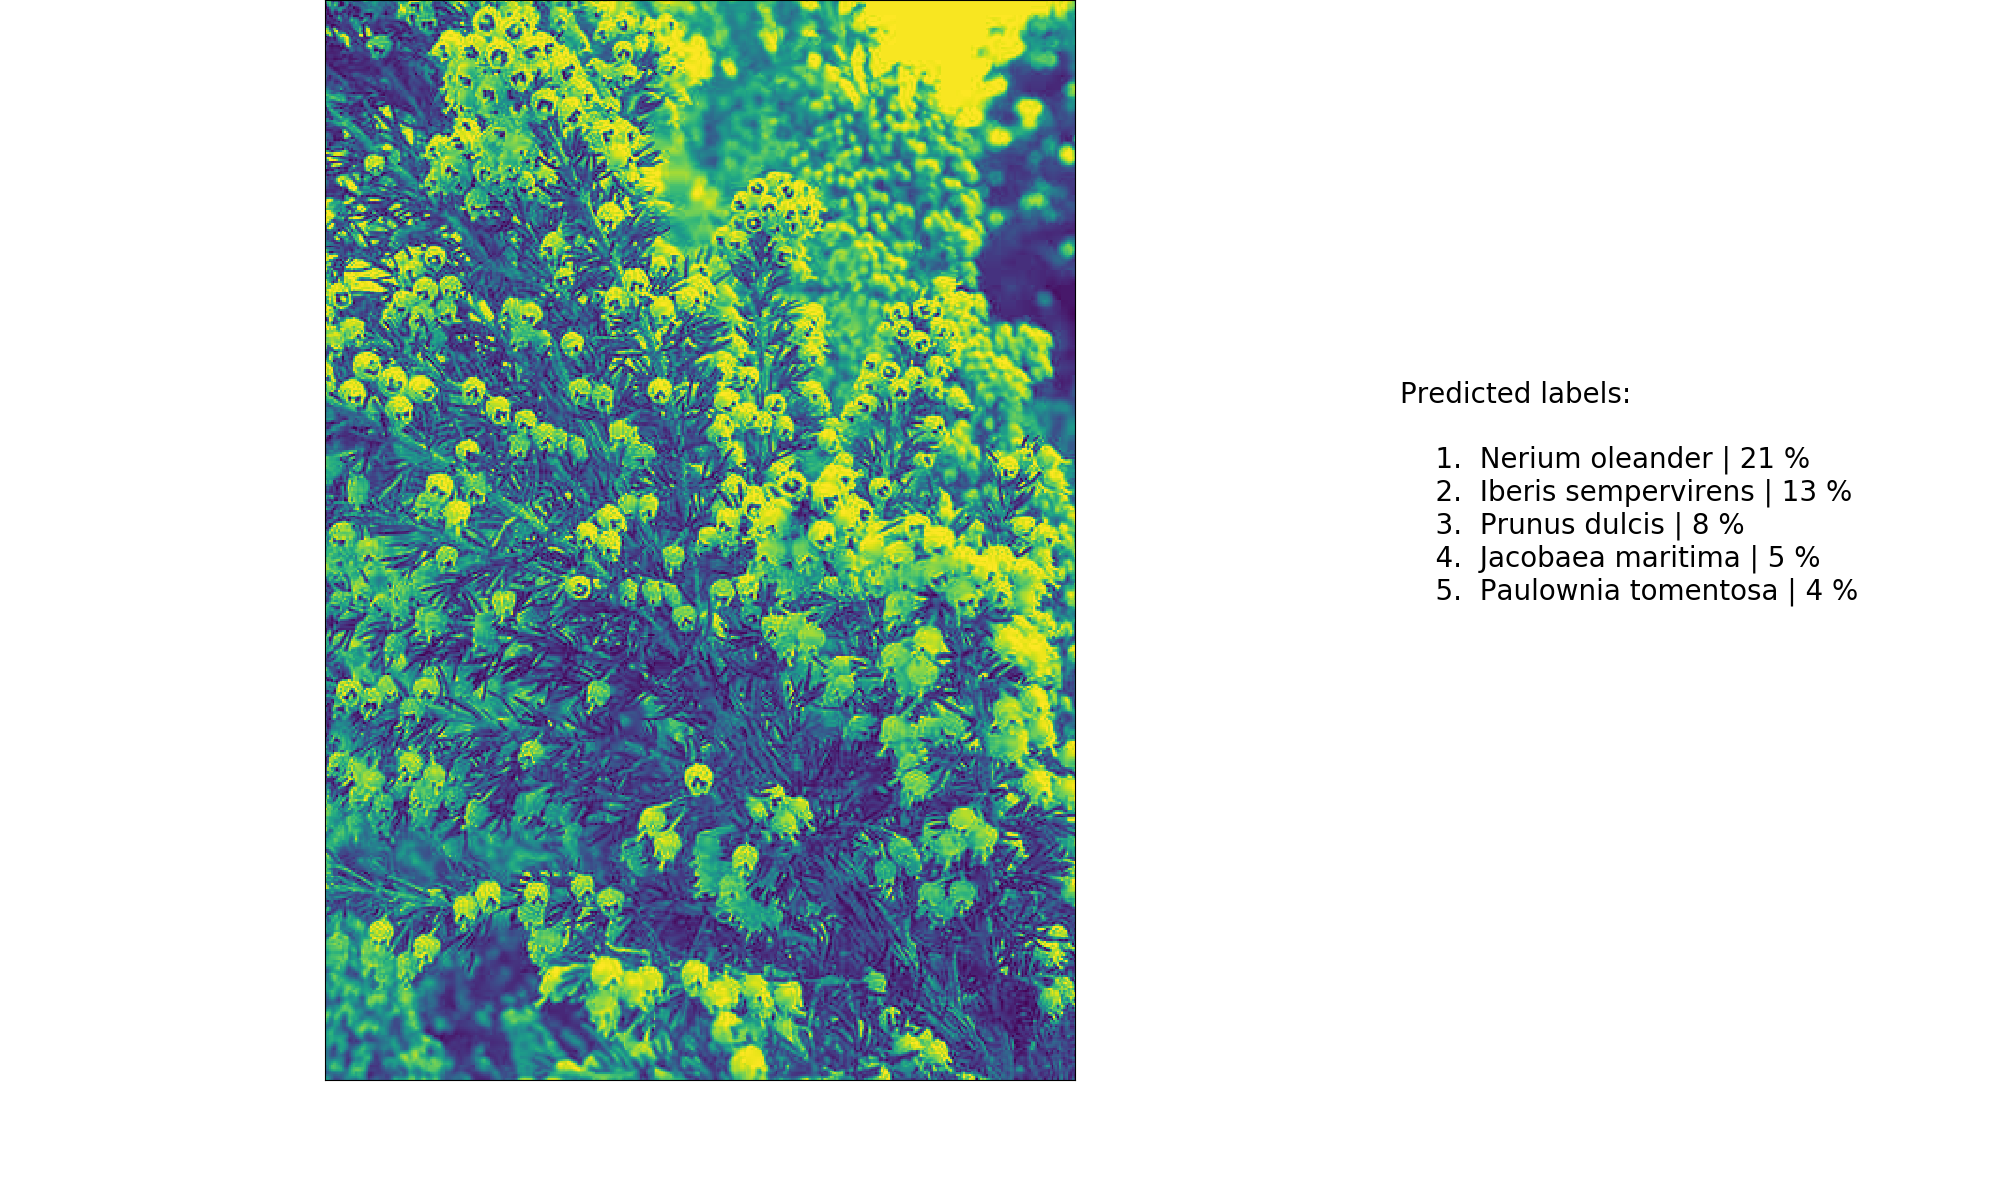

In [6]:
for input_image_path in input_image_files:
    try:
        print(f"Processing image: {input_image_path}")

        output_file_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(input_image_path)}_output.txt")
        output_image_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(input_image_path)}_processed.jpg")

        response = oscar_client.run_service(
            SERVICE_NAME,
            input=input_image_path,
            output=output_file_path
        )
        print(f"Service run successfully for {input_image_path}.")
        max_wait_time = 300
        elapsed_time = 0
        while not os.path.exists(output_file_path) and elapsed_time < max_wait_time:
            print(f"Waiting for output file: {output_file_path}")
            time.sleep(5)
            elapsed_time += 5

        if not os.path.exists(output_file_path):
            raise FileNotFoundError(f"Output file was not created for {input_image_path} at {output_file_path}")

        with open(output_file_path, 'r') as f:
            content = f.read()

        base64_data = extract_base64_content(content)
        image_data = base64.b64decode(base64_data)

        with open(output_image_path, 'wb') as img_file:
            img_file.write(image_data)
        print(f"Processed image saved to: {output_image_path}")

        image = PILImage.open(BytesIO(image_data))
        display(image)

    except Exception as e:
        print(f"Error processing {input_image_path}: {e}")
